############## Importamos funciones a utilizar ###################

In [7]:
# Computación científica
import numpy as np

# Gráficos
import matplotlib.pyplot as plt

# Mapas de colores
from matplotlib import cm

# Funciones especiales
from scipy.special import erf, erfc

####### Definimos parametros fisicos y condiciones asociadas al panel ##############

In [26]:
#[1] J. C. Sánchez Barroso, N. Barth, J. P. M. Correia, S. Ahzi, and M. A. Khaleel,
#"A computational analysis of coupled thermal and electrical behavior of PV panels,"
#Solar Energy Materials and Solar Cells, vol. 148, pp. 73–86, 2016.


#se extrajeron datos de las propiedades fisicas de cada placa de PV Panel BP 350
#Se construye un diccionario con los datos extraidos para cada capa del panel:
layers = {
    "Glass":       {"L": 3e-3,     "k": 1.8,   "rho": 3000, "cp": 500},
    "ARC":         {"L": 0.0001e-3,"k": 32,    "rho": 2400, "cp": 691},
    "PV Cells":    {"L": 0.225e-3, "k": 148,   "rho": 2330, "cp": 677},
    "EVA":         {"L": 0.5e-3,   "k": 0.35,  "rho": 960,  "cp": 2090},
    "RearContact": {"L": 0.01e-3,  "k": 237,   "rho": 2700, "cp": 900},
    "Tedlar":      {"L": 0.1e-3,   "k": 0.2,   "rho": 1200, "cp": 1250}
}

#Extraccion de listas del diccionario:
L_i   = np.array([layer["L"]   for layer in layers.values()])
k_i   = np.array([layer["k"]   for layer in layers.values()])
rho_i = np.array([layer["rho"] for layer in layers.values()])
cp_i  = np.array([layer["cp"]  for layer in layers.values()])

#Se calcula el espesor total del panel como la suma de los espesores de cada placa
L = np.sum(L_i)

# Se calcula la conductividad como la relacion entre el largo total
# dividido por la resistencia total
#que resulta en la sumatoria de las divisiones de cada tramo 
#por su conductividad electrica
k = L / np.sum(L_i / k_i)


#calculo de la densidad, como el promedio ponderado de los volumenes
rho = np.sum(rho_i * L_i) / L

#calculo del calor especifico como el promedio ponderado
#de la masa y su capacidad calorica
cp = np.sum(rho_i * cp_i * L_i) / (rho * L)

#calculo de la difusividad termica como k/rho*Cp
alpha = k / (rho* cp)

#Coeficiente de Conveccion natural (extraido de Sánchez Barroso, 2016)
h_conv = 5.81 

#para la absorvancia se utilizo un valor promedio dentro de rangos aceptados en la literatura 
#[2] A. H. M. Almawgani, A. Alzahrani, A. Hajjiah, A. Mehaney,
#H. A. Elsayed & H. Sayed, “Optical absorption performance of CZTS/ZnO 
#thin film solar cells comprising anti-reflecting coating of texturing configuration,” 
#RSC Advances, vol. 13, núm. 45, pp. 31554–31568, 2023. doi:10.1039/d3ra05056d
alpha_abs = 0.9  

#Calculo de la eficiencia electrica dados los datos del panel " BP350U"
#[3] BP Solar, “BP 350U Photovoltaic Module — Datasheet,” Farnell,
#[en línea] Disponible: https://www.farnell.com/datasheets/310484.pdf
P_max = 50      # Potencia máxima en W
G = 1000        # Irradiancia en W/m^2 (STC)
L_panel = 0.839       # Largo en metros (desde el datasheet)
W_panel = 0.537       # Ancho en metros (desde el datasheet)
A = L_panel * W_panel       #area del panel
# Eficiencia eléctrica en STC
n_ref = P_max / (G * A)


#calculo de coeficiente de temperatura de eficiencia
gamma_P_percent = -0.5  # [%/°C]
gamma_P = gamma_P_percent / 100.0  # → -0.005 1/°C

# coeficiente de temperatura de eficiencia
b = -gamma_P  # → 0.005 1/°C

#temperatura ambiental de referencia
T_ref = 298.15     


#definimos los parametros de la simulacion #############

In [27]:
# numero de nodos en dimension z
n_z = 10 
#dominio discretizado: espaciamiento lineal entre 0 y L, con n_z+1 elementos 
z = np.linspace(0, L, n_z + 1) 

# espaciamineto del reticulado 
dz = L / n_z       

# calculo del dt máximo estable
dt_max = dz**2 / (2*alpha)
dt = 0.9 * dt_max   

# condición inicial
T_0 = 298.15  

# vector de temperaturas T 
T   = np.ones(n_z + 1) * T_0       
T_new = T.copy()

# tiempo inicial
t_0 = 0.0
#tiempo final de integracion
t_f = 86400   

# numero de pasos del integrador
n_steps = int((t_f - t_0) / dt)


# definir cuántos perfiles queremos guardar para graficar
num_outputs = 200            
write_interval = max(1, n_steps // num_outputs)

####Definicion de funciones auxiliares a utilizar en el modelo ##### 

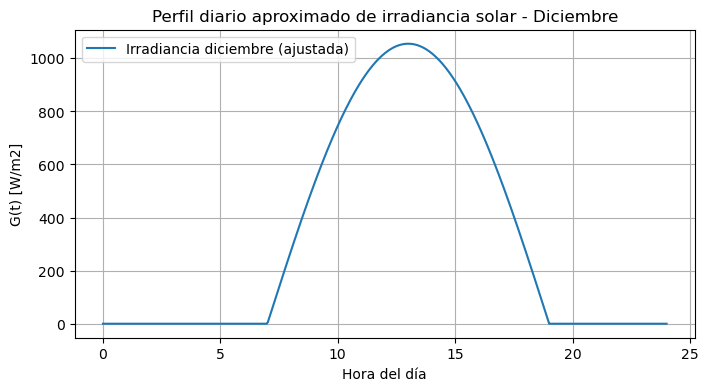

In [29]:
#Datos de irradacion solar acumulada por dia promedio en la zona norte de Chile para el mes de diciembre:
#extraidos de [1] Comisión Nacional de Energía (CNE), 
#“Modelación de Recursos Solar y Eólico en Chile,” 
#Gobierno de Chile, Santiago, 2010. [En línea]. 
#Disponible en: https://www.energia.gob.cl/sites/default/files/modelacionrecursosolareolico.pdf

E_day_kWh = 8.06        # kWh/m2/día
E_day_Wh = E_day_kWh * 1000  # Wh/m2/día

# simulacion dia solar 
t_sol = 12  # horas de sol
t_sol_s = t_sol * 3600  # horas de sol en segundos

# horas amanecer - atardecer
t_sunrise = 7      # amanecer
t_sunset  = 19     # atardecer
t_sol = t_sunset - t_sunrise  # 12 horas de sol en total

# calculo de irradiancia dado un modelo de radiacion sinusoideal, ajustado a los datos reales ( alcanza un maximo a medio dia)
G_max = (np.pi / 2) * (E_day_Wh / t_sol)

# funcion de irradiacion solar
def G_solar(t):
    t_h = t / 3600 
    if t_sunrise <= t_h <= t_sunset:
        tau = t_h - t_sunrise
        return G_max * np.sin(np.pi * tau / t_sol)
    else:
        return 0.0
# para ver los resultados de la simulacion 
#se procede a graficar un perfil de irradacion para un dia
t_hours = np.linspace(0, 24, 500)
G_values = [G_solar(t*3600) for t in t_hours]
plt.figure(figsize=(8,4))
plt.plot(t_hours, G_values, label="Irradiancia diciembre (ajustada)")
plt.xlabel("Hora del día")
plt.ylabel("G(t) [W/m2]")
plt.title("Perfil diario aproximado de irradiancia solar - Diciembre")
plt.grid(True)
plt.legend()
plt.show()
       
# funcion temperatura ambiental
def T_amb(t):
    return 298.15
    
# funcion de calculo de la eficiencia electrica dada la temperatura ( relacion inversamente proporcional)
def eficiencia(T_surf):
    return n_ref * (1.0 - b * (T_surf - T_ref))


#Aplicacion del metodo de diferencias finitas explicito ###

In [30]:
# lista donde se almacenaran los perfiles de temperatura
hist_T = []

# bucle de un dia para generar instancias de la simulacion
for step in range(n_steps):
    # tiempo fisico 
    t = step * dt
    # condicion de borde frontal para el nodo 1
    eta_1 = eficiencia(T[1])
    q_solar = alpha_abs * G_solar(t) * (1 - eta_1)
    T_new[0] = T[1] + (dz/k) * q_solar
    
    # aplicacion del metodo ftcs a la ecuacion de difusion para los nodos interiores
    for j in range(1, n_z):
        T_new[j] = T[j] + alpha * dt * (T[j+1] - 2*T[j] + T[j-1]) / dz**2
        
    #condicion de borde posterior para el ultimo nodo
    T_new[n_z] = ((k/dz)*T[n_z-1] + h_conv * T_amb(t)) / ((k/dz) + h_conv)

    # actualización del paso a la lista
    T[:] = T_new[:]

    # guardar perfiles cada cierto número de pasos, para ayudar a convergencia del metodo
    if step % write_interval == 0:
        #se imprimen los valores para verificar la correcta eplicacion del metodo
        if step % write_interval == 0:
            print(f"t = {t/3600:.2f} h, T_surf = {T[0]:.2f} K, T_back = {T[-1]:.2f} K")
        hist_T.append(T.copy())


t = 0.00 h, T_surf = 298.15 K, T_back = 298.15 K
t = 0.12 h, T_surf = 298.15 K, T_back = 298.15 K
t = 0.24 h, T_surf = 298.15 K, T_back = 298.15 K
t = 0.36 h, T_surf = 298.15 K, T_back = 298.15 K
t = 0.48 h, T_surf = 298.15 K, T_back = 298.15 K
t = 0.60 h, T_surf = 298.15 K, T_back = 298.15 K
t = 0.72 h, T_surf = 298.15 K, T_back = 298.15 K
t = 0.84 h, T_surf = 298.15 K, T_back = 298.15 K
t = 0.96 h, T_surf = 298.15 K, T_back = 298.15 K
t = 1.08 h, T_surf = 298.15 K, T_back = 298.15 K
t = 1.20 h, T_surf = 298.15 K, T_back = 298.15 K
t = 1.32 h, T_surf = 298.15 K, T_back = 298.15 K
t = 1.44 h, T_surf = 298.15 K, T_back = 298.15 K
t = 1.56 h, T_surf = 298.15 K, T_back = 298.15 K
t = 1.68 h, T_surf = 298.15 K, T_back = 298.15 K
t = 1.80 h, T_surf = 298.15 K, T_back = 298.15 K
t = 1.92 h, T_surf = 298.15 K, T_back = 298.15 K
t = 2.04 h, T_surf = 298.15 K, T_back = 298.15 K
t = 2.16 h, T_surf = 298.15 K, T_back = 298.15 K
t = 2.28 h, T_surf = 298.15 K, T_back = 298.15 K
t = 2.40 h, T_surf =

#Graficos para analisis##

In [33]:
# lista de vectores con perfiles de temperatura
hist_arr = np.array(hist_T)     

# vector de tiempos asociado a cada perfil
n_snapshots = hist_arr.shape[0]

# tiempo en segundos
t_hist = np.arange(n_snapshots) * write_interval * dt  

# tiempo en horas
t_hist_h = t_hist / 3600.0                 



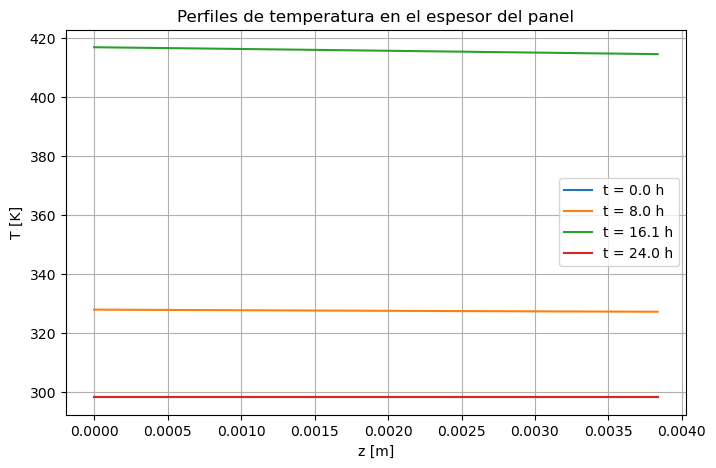

In [35]:
# perfil de temperatura en el espesor del panel

plt.figure(figsize=(8,5))
idx0 = 0
idx1 = n_snapshots // 3
idx2 = 2 * n_snapshots // 3
idx3 = n_snapshots - 1
plt.plot(z, hist_arr[idx0], label=f"t = {t_hist_h[idx0]:.1f} h")
plt.plot(z, hist_arr[idx1], label=f"t = {t_hist_h[idx1]:.1f} h")
plt.plot(z, hist_arr[idx2], label=f"t = {t_hist_h[idx2]:.1f} h")
plt.plot(z, hist_arr[idx3], label=f"t = {t_hist_h[idx3]:.1f} h")
plt.xlabel("z [m]")
plt.ylabel("T [K]")
plt.title("Perfiles de temperatura en el espesor del panel")
plt.grid(True)
plt.legend()
plt.show()


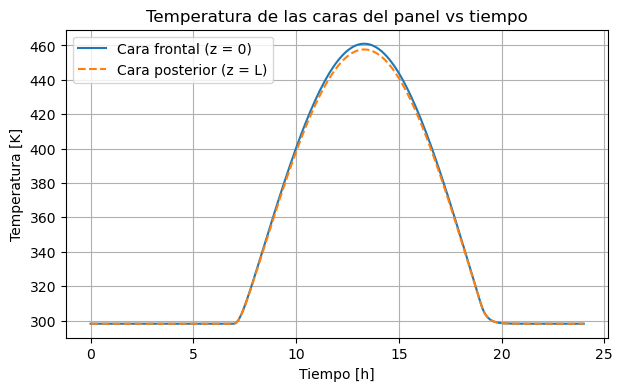

In [39]:
# Temperaturas caras del panel versus tiempo 
T_surf_hist = hist_arr[:, 0]
# Cara posterior = nodo j = n_z
T_back_hist = hist_arr[:, n_z]
plt.figure(figsize=(7,4))
plt.plot(t_hist_h, T_surf_hist, label="Cara frontal (z = 0)")
plt.plot(t_hist_h, T_back_hist, label="Cara posterior (z = L)", linestyle="--")
plt.xlabel("Tiempo [h]")
plt.ylabel("Temperatura [K]")
plt.title("Temperatura de las caras del panel vs tiempo")
plt.grid(True)
plt.legend()
plt.show()


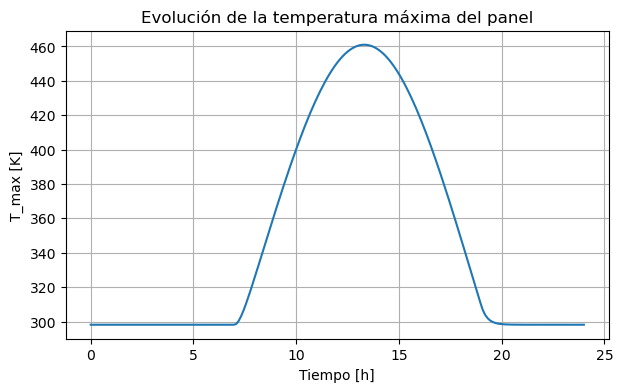

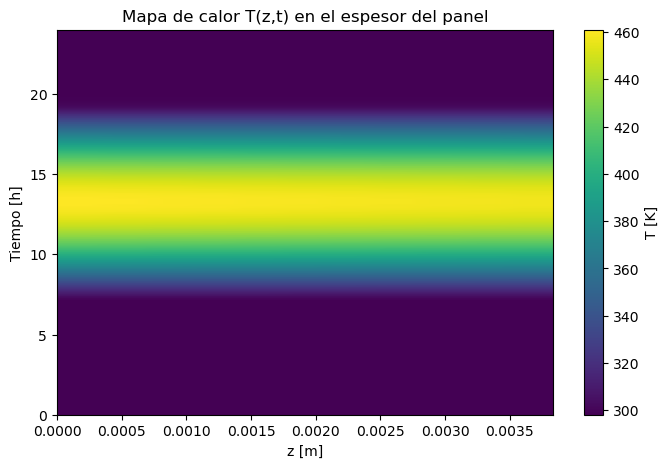

In [22]:
#mapa de calor en el espesro del panel
plt.figure(figsize=(8,5))
# imshow espera: (tiempo, espacio)
plt.imshow(hist_arr,
           aspect='auto',
           origin='lower',
           extent=[0, L, t_hist_h[0], t_hist_h[-1]])
plt.colorbar(label="T [K]")
plt.xlabel("z [m]")
plt.ylabel("Tiempo [h]")
plt.title("Mapa de calor T(z,t) en el espesor del panel")
plt.show()



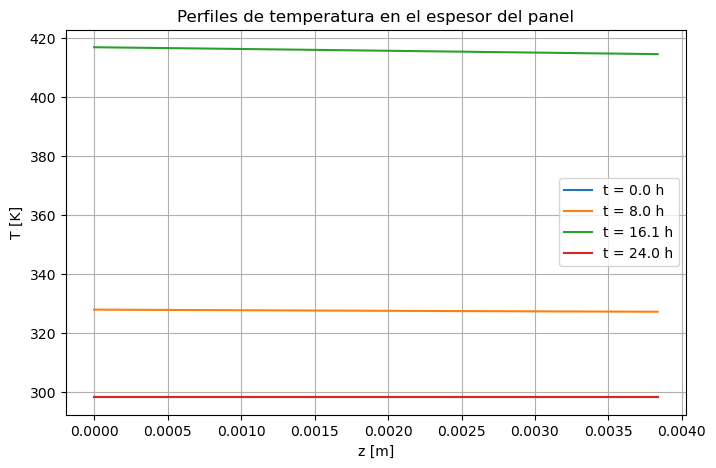

In [23]:
plt.figure(figsize=(8,5))

idx0 = 0
idx1 = n_snapshots // 3
idx2 = 2 * n_snapshots // 3
idx3 = n_snapshots - 1

plt.plot(z, hist_arr[idx0], label=f"t = {t_hist_h[idx0]:.1f} h")
plt.plot(z, hist_arr[idx1], label=f"t = {t_hist_h[idx1]:.1f} h")
plt.plot(z, hist_arr[idx2], label=f"t = {t_hist_h[idx2]:.1f} h")
plt.plot(z, hist_arr[idx3], label=f"t = {t_hist_h[idx3]:.1f} h")

plt.xlabel("z [m]")
plt.ylabel("T [K]")
plt.title("Perfiles de temperatura en el espesor del panel")
plt.grid(True)
plt.legend()
plt.show()



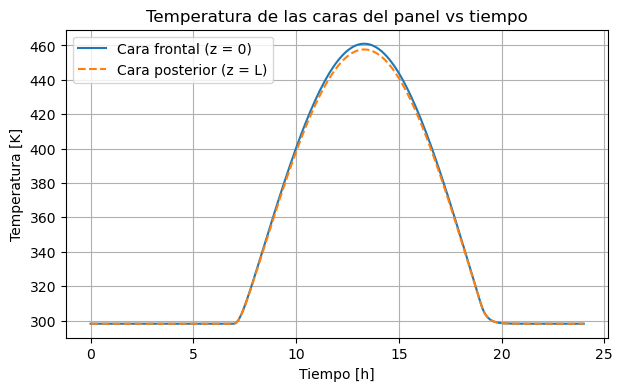

In [24]:
# Cara frontal = nodo j = 0
T_surf_hist = hist_arr[:, 0]

# Cara posterior = nodo j = n_z
T_back_hist = hist_arr[:, n_z]

plt.figure(figsize=(7,4))
plt.plot(t_hist_h, T_surf_hist, label="Cara frontal (z = 0)")
plt.plot(t_hist_h, T_back_hist, label="Cara posterior (z = L)", linestyle="--")
plt.xlabel("Tiempo [h]")
plt.ylabel("Temperatura [K]")
plt.title("Temperatura de las caras del panel vs tiempo")
plt.grid(True)
plt.legend()
plt.show()


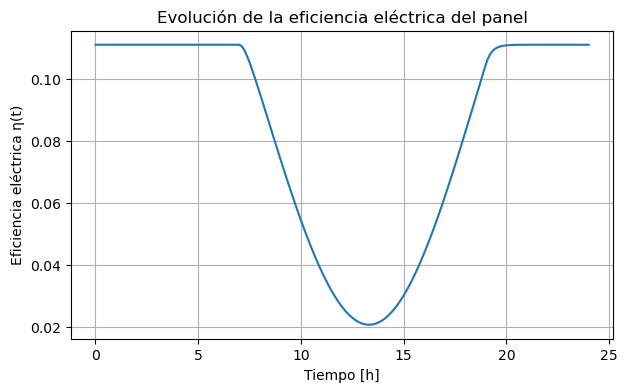

In [25]:
eta_hist = eficiencia(T_surf_hist)   # eficiencia en la superficie frontal

plt.figure(figsize=(7,4))
plt.plot(t_hist_h, eta_hist)
plt.xlabel("Tiempo [h]")
plt.ylabel("Eficiencia eléctrica η(t)")
plt.title("Evolución de la eficiencia eléctrica del panel")
plt.grid(True)
plt.show()
